In [1]:
!pip install -U transformers accelerate datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 136.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 56.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.3
    Uninstalling transformers-4.57.3:
      Successfully uninstalled transformers-4.57.3
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [2]:
import os
import json
import glob
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    EvalPrediction
)
from transformers import TrainingArguments
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
class Args:
    output_dir = "output"
    model_path = "klue/roberta-base"
    tokenizer = "klue/roberta-base"
    max_seq_len = 256
    batch_size = 512
    valid_batch_size = 512
    accumulate_grad_batches = 1
    epochs = 3
    learning_rate = 2e-5
    weight_decay = 0.0
    seed = 42

args = Args()
os.makedirs(args.output_dir, exist_ok=True)

# Set seeds
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(args.seed)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def load_csv_data(directory):
    all_files_in_dir = glob.glob(os.path.join(directory, "*.csv"))
    df_list = []
    print(f"Loading CSV files from: {directory}")

    if not all_files_in_dir:
        print(f"No CSV files found in {directory}. Returning empty DataFrame.")
        return pd.DataFrame()

    for file_path in all_files_in_dir:
        filename = os.path.basename(file_path)
        print(f"Attempting to load: {file_path}")
        current_df = None
        try:
            current_df = pd.read_csv(file_path, encoding='utf-8')
            print(f"Successfully loaded {filename} with utf-8 encoding.")
        except UnicodeDecodeError:
            try:
                current_df = pd.read_csv(file_path, encoding='cp949')
                print(f"Successfully loaded {filename} with cp949 encoding.")
            except UnicodeDecodeError:
                try:
                    current_df = pd.read_csv(file_path, encoding='euc-kr')
                    print(f"Successfully loaded {filename} with euc-kr encoding.")
                except pd.errors.EmptyDataError:
                    print(f"Skipping empty CSV file: {filename}")
                except FileNotFoundError:
                    print(f"File not found: {filename}")
                except Exception as e:
                    print(f"Error loading {filename} with euc-kr encoding: {e}")
            except pd.errors.EmptyDataError:
                print(f"Skipping empty CSV file: {filename}")
            except FileNotFoundError:
                print(f"File not found: {filename}")
            except Exception as e:
                print(f"An unexpected error occurred while loading {filename} with cp949 encoding: {e}")
        except pd.errors.EmptyDataError:
            print(f"Skipping empty CSV file: {filename}")
        except FileNotFoundError:
            print(f"File not found: {filename}")
        except Exception as e:
            print(f"An unexpected error occurred while loading {filename} with utf-8 encoding: {e}")

        if current_df is not None:
            df_list.append(current_df)

    if df_list:
        return pd.concat(df_list, ignore_index=True)
    else:
        print(f"No dataframes were successfully loaded from {directory}. Returning empty DataFrame.")
        return pd.DataFrame()

print("Loading Train Data...")
all_train_df = load_csv_data("/content/drive/MyDrive/data/csv_train_data")
print("Loading Validation Data...")
test_df = load_csv_data("/content/drive/MyDrive/data/csv_val_data")

# Train 데이터를 다시 Train(90%)과 Validation(10%)으로 분할
train_df, val_df = train_test_split(
    all_train_df,
    test_size=0.1,
    random_state=args.seed,
    shuffle=True
)

labels = ['linguistic_acceptability', 'consistency', 'interestingness', 'unbias',
          'harmlessness', 'no_hallucination', 'understandability', 'sensibleness', 'specificity']

id2label = {idx: label for idx, label in enumerate(labels)}
label2id = {label: idx for idx, label in enumerate(labels)}

with open(os.path.join(args.output_dir, "label2id.json"), "w") as f:
    json.dump(label2id, f)

print(f"최종 데이터 구성:")
print(f" - Train      : {len(train_df)} rows")
print(f" - Validation : {len(val_df)} rows")
print(f" - Test       : {len(test_df)} rows (Original Validation)")


Loading Train Data...
Loading CSV files from: /content/drive/MyDrive/data/csv_train_data
Attempting to load: /content/drive/MyDrive/data/csv_train_data/TL_TL_발화·대화단위 평가 데이터_TL_기술_과학.csv
Successfully loaded TL_TL_발화·대화단위 평가 데이터_TL_기술_과학.csv with utf-8 encoding.
Attempting to load: /content/drive/MyDrive/data/csv_train_data/TL_TL_발화·대화단위 평가 데이터_TL_미용_건강_식음료.csv
Successfully loaded TL_TL_발화·대화단위 평가 데이터_TL_미용_건강_식음료.csv with utf-8 encoding.
Attempting to load: /content/drive/MyDrive/data/csv_train_data/TL_TL_발화·대화단위 평가 데이터_TL_경제활동_상품상거래.csv
Successfully loaded TL_TL_발화·대화단위 평가 데이터_TL_경제활동_상품상거래.csv with utf-8 encoding.
Attempting to load: /content/drive/MyDrive/data/csv_train_data/TL_TL_발화·대화단위 평가 데이터_TL_엔터테인먼트_오락_예술.csv
Successfully loaded TL_TL_발화·대화단위 평가 데이터_TL_엔터테인먼트_오락_예술.csv with

In [6]:
def consolidate_labels_by_voting(df: pd.DataFrame) -> pd.DataFrame:
    # Define mapping for 'yes'/'no' to numerical values
    label_to_numeric = {'yes': 1, 'no': 0}

    # Apply mapping to label columns
    df_numeric = df.copy()
    for label_col in labels:
        df_numeric[label_col] = df_numeric[label_col].map(label_to_numeric)

    # Define aggregation logic
    aggregation_dict = {'text': 'first'}
    for label_col in labels:
        aggregation_dict[label_col] = 'sum'

    # Group by conversation_id and utterance_id and aggregate
    grouped_df = df_numeric.groupby(['conversation_id', 'utterance_id']).agg(aggregation_dict).reset_index()

    # Convert summed numerical labels back to 'yes'/'no' based on voting rule
    for label_col in labels:
        grouped_df[label_col] = grouped_df[label_col].apply(lambda x: 'yes' if x >= 2 else 'no')

    return grouped_df

print("Function `consolidate_labels_by_voting` defined successfully.")

Function `consolidate_labels_by_voting` defined successfully.


In [7]:
print("Consolidating train_df...")
consolidated_train_df = consolidate_labels_by_voting(train_df)

print("Consolidating val_df...")
consolidated_val_df = consolidate_labels_by_voting(val_df)

print("Consolidating test_df...")
consolidated_test_df = consolidate_labels_by_voting(test_df)

print("Consolidated Train DataFrame Head:")
print(consolidated_train_df.head())

print("\nConsolidated Train DataFrame Shape:")
print(consolidated_train_df.shape)

print("Consolidated Validation DataFrame Head:")
print(consolidated_val_df.head())

print("\nConsolidated Validation DataFrame Shape:")
print(consolidated_val_df.shape)

print("Consolidated Test DataFrame Head:")
print(consolidated_test_df.head())

print("\nConsolidated Test DataFrame Shape:")
print(consolidated_test_df.shape)

Consolidating train_df...
Consolidating val_df...
Consolidating test_df...
Consolidated Train DataFrame Head:
   conversation_id utterance_id  \
0                1       c1.u10   
1                1       c1.u12   
2                1       c1.u14   
3                1       c1.u16   
4                1        c1.u2   

                                                text linguistic_acceptability  \
0  네, 최근에도 도서관에서 성교육, 성평등 도서를 빼라는 요구가 있었고, 이에 대한 ...                       no   
1  금서일기주간을 맞아 도서관에 대한 검열을 반대하는 플래시몹이 진행될 예정이에요. 또...                       no   
2  금서일기주간에 참여하려면 역사상 금서였던 책을 구입하거나 대출해서 읽어보는 것이 좋...                       no   
3                                  제가 도움이 되었으면 좋겠내요!                       no   
4  독서문화시민연대는 독서를 통해 시민들이 생각하고 판단하며 성찰하는 시민이 되기 위해...                       no   

  consistency interestingness unbias harmlessness no_hallucination  \
0         yes             yes    yes          yes              yes   
1         yes             yes    yes          yes   

In [8]:
def create_conversation_history(df: pd.DataFrame) -> pd.DataFrame:
    df_with_history = df.copy()

    # 정렬을 위해 utterance_id에서 숫자 추출
    df_with_history['utterance_num'] = df_with_history['utterance_id'].apply(lambda x: int(x.split('u')[1]))
    df_with_history = df_with_history.sort_values(by=['conversation_id', 'utterance_num']).reset_index(drop=True)

    # 'context' 컬럼 생성 (이전 대화들이 합쳐질 공간)
    df_with_history['context'] = ''

    # 대화 ID별로 그룹화하여 맥락 생성
    # 수정된 로직 예시 (최근 5개만 유지)
    for conv_id, group in df_with_history.groupby('conversation_id'):
        history_list = []
        for idx in group.index:
            # 최근 5개의 대화만 합쳐서 context 생성
            recent_history = history_list[-5:]
            combined_history = " [SEP] ".join(recent_history) # 구분자를 주면 더 좋습니다
            df_with_history.loc[idx, 'context'] = combined_history

            history_list.append(df_with_history.loc[idx, 'text'])

    df_with_history = df_with_history.drop(columns=['utterance_num'])
    return df_with_history

print("Function `create_conversation_history` defined successfully.")

Function `create_conversation_history` defined successfully.


In [9]:
print("Creating conversation history for train_df...")
train_df_with_history = create_conversation_history(consolidated_train_df)

print("Creating conversation history for val_df...")
val_df_with_history = create_conversation_history(consolidated_val_df)

print("Creating conversation history for test_df...")
test_df_with_history = create_conversation_history(consolidated_test_df)

print("Train DataFrame with History Head:")
display(train_df_with_history.head())

print("\nValidation DataFrame with History Head:")
display(val_df_with_history.head())

print("\nTest DataFrame with History Head:")
display(test_df_with_history.head())

Creating conversation history for train_df...
Creating conversation history for val_df...
Creating conversation history for test_df...
Train DataFrame with History Head:


,conversation_id,utterance_id,text,linguistic_acceptability,consistency,interestingness,unbias,harmlessness,no_hallucination,understandability,sensibleness,specificity,context
0,1,c1.u2,독서문화시민연대는 독서를 통해 시민들이 생각하고 판단하며 성찰하는 시민이 되기 위해...,no,yes,yes,yes,yes,yes,no,yes,yes,
1,1,c1.u4,"금서읽기주간은 2015년에 시작된 행사로, 보수단체의 도서 검열 운동에 대항하기 위...",no,yes,yes,yes,yes,yes,yes,yes,yes,독서문화시민연대는 독서를 통해 시민들이 생각하고 판단하며 성찰하는 시민이 되기 위해...
2,1,c1.u6,금서읽기주간에서는 과거에 금서로 지정되었던 책들을 읽고 토론하는 것이 주요 활동입니...,no,yes,yes,yes,yes,yes,yes,yes,yes,독서문화시민연대는 독서를 통해 시민들이 생각하고 판단하며 성찰하는 시민이 되기 위해...
3,1,c1.u8,"과거에는 권력자들이 통제를 위해 금서를 지정했는데, 예를 들어 젊은 베르테르의 슬픔...",no,yes,yes,yes,yes,yes,yes,yes,yes,독서문화시민연대는 독서를 통해 시민들이 생각하고 판단하며 성찰하는 시민이 되기 위해...
4,1,c1.u10,"네, 최근에도 도서관에서 성교육, 성평등 도서를 빼라는 요구가 있었고, 이에 대한 ...",no,yes,yes,yes,yes,yes,yes,yes,yes,독서문화시민연대는 독서를 통해 시민들이 생각하고 판단하며 성찰하는 시민이 되기 위해...



Validation DataFrame with History Head:


,conversation_id,utterance_id,text,linguistic_acceptability,consistency,interestingness,unbias,harmlessness,no_hallucination,understandability,sensibleness,specificity,context
0,1,c1.u2,독서문화시민연대는 독서를 통해 시민들이 생각하고 판단하며 성찰하는 시민이 되기 위해...,no,no,no,no,no,no,no,no,no,
1,1,c1.u4,"금서읽기주간은 2015년에 시작된 행사로, 보수단체의 도서 검열 운동에 대항하기 위...",no,no,no,no,no,no,no,no,no,독서문화시민연대는 독서를 통해 시민들이 생각하고 판단하며 성찰하는 시민이 되기 위해...
2,1,c1.u10,"네, 최근에도 도서관에서 성교육, 성평등 도서를 빼라는 요구가 있었고, 이에 대한 ...",no,no,no,no,no,no,no,no,no,독서문화시민연대는 독서를 통해 시민들이 생각하고 판단하며 성찰하는 시민이 되기 위해...
3,1,c1.u14,금서일기주간에 참여하려면 역사상 금서였던 책을 구입하거나 대출해서 읽어보는 것이 좋...,no,no,no,no,no,no,no,no,no,독서문화시민연대는 독서를 통해 시민들이 생각하고 판단하며 성찰하는 시민이 되기 위해...
4,2,c2.u6,"네, 확실히 그렇네요.",no,no,no,no,no,no,no,no,no,



Test DataFrame with History Head:


,conversation_id,utterance_id,text,linguistic_acceptability,consistency,interestingness,unbias,harmlessness,no_hallucination,understandability,sensibleness,specificity,context
0,5,c5.u2,"네, 최헌의 앵두는 2023년에 젊은이들 사이에서 인기를 끌었어요. 이 곡은 그 당...",yes,yes,yes,yes,yes,yes,yes,yes,yes,
1,5,c5.u4,"네, 그렇게 봐야죠.",yes,yes,yes,yes,yes,yes,yes,yes,yes,"네, 최헌의 앵두는 2023년에 젊은이들 사이에서 인기를 끌었어요. 이 곡은 그 당..."
2,5,c5.u6,"'밀수'는 여러 옛 노래들이 사용되었어요. 예를 들면 '잘 살아보세', '연안부두'...",yes,yes,yes,yes,yes,yes,yes,yes,yes,"네, 최헌의 앵두는 2023년에 젊은이들 사이에서 인기를 끌었어요. 이 곡은 그 당..."
3,5,c5.u8,'밀수'에서 사용된 옛 노래들은 극적인 효과를 주었어요. 이 노래들은 각 장면과 인...,yes,yes,yes,yes,yes,yes,yes,yes,yes,"네, 최헌의 앵두는 2023년에 젊은이들 사이에서 인기를 끌었어요. 이 곡은 그 당..."
4,5,c5.u10,'마스크걸'에서는 김모미의 내면을 대변하는 옛 음악들이 사용되었어요. 예를 들면 김...,yes,yes,yes,yes,yes,yes,yes,yes,yes,"네, 최헌의 앵두는 2023년에 젊은이들 사이에서 인기를 끌었어요. 이 곡은 그 당..."


In [15]:
tokenizer = AutoTokenizer.from_pretrained(args.tokenizer)

def preprocess_function(examples):
    # Segment A: context (그전 대화 맥락)
    # Segment B: text (평가 대상 발화)
    # truncation="only_first"는 전체 길이가 길어질 때
    # 평가 대상인 Segment B(현재 발화)는 보존하고 맥락인 Segment A의 앞쪽을 자르라는 의미입니다.

    # 'text'나 'context'가 None(NaN)인 경우를 대비해 빈 문자열 처리
    texts = [str(t) if t is not None else "" for t in examples["text"]]
    contexts = [str(c) if c is not None else "" for c in examples["context"]]

    # 두 문장을 결합하여 토큰화 (truncation_side='left'에 의해 앞의 context부터 잘림)
    encoding = tokenizer(
        contexts, # 첫 번째 문장 (맥락)
        texts,    # 두 번째 문장 (현재 발화)
        truncation="longest_first",
        padding="max_length",
        max_length=args.max_seq_len
    )
    # 레이블 처리 (기존과 동일)
    labels_matrix = []
    for i in range(len(examples["text"])):
        label_vector = [1.0 if examples[label][i] == 'yes' else 0.0 for label in labels]
        labels_matrix.append(label_vector)
    encoding["labels"] = labels_matrix
    return encoding

# Convert to HuggingFace Dataset, using the new DataFrames with history
train_dataset = Dataset.from_pandas(train_df_with_history)
val_dataset = Dataset.from_pandas(val_df_with_history)
test_dataset = Dataset.from_pandas(test_df_with_history)

print("Tokenizing Datasets with conversation history...")
encoded_train = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.column_names)
encoded_val = val_dataset.map(preprocess_function, batched=True, remove_columns=val_dataset.column_names)
encoded_test = test_dataset.map(preprocess_function, batched=True, remove_columns=test_dataset.column_names)


Tokenizing Datasets with conversation history...


Map:   0%|          | 0/400176 [00:00<?, ? examples/s]

Map:   0%|          | 0/108601 [00:00<?, ? examples/s]

Map:   0%|          | 0/50047 [00:00<?, ? examples/s]

In [12]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(
    args.model_path,
    problem_type="multi_label_classification",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)


def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    # Apply sigmoid
    probs = 1 / (1 + np.exp(-preds))
    y_pred = (probs >= 0.5).astype(int)
    y_true = p.label_ids.astype(int)

    # Metrics
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)

    return {
        'accuracy': accuracy,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro
    }

training_args = TrainingArguments(
    output_dir=args.output_dir,
    learning_rate=args.learning_rate,
    per_device_train_batch_size=args.batch_size,
    per_device_eval_batch_size=args.valid_batch_size,
    gradient_accumulation_steps=args.accumulate_grad_batches,
    num_train_epochs=args.epochs,
    weight_decay=args.weight_decay,
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    logging_dir='./logs',
    logging_strategy="steps",
    logging_steps=500,
    eval_strategy="steps",
    eval_steps=500
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

print("Starting Training...")
train_result = trainer.train()

SAVE_PATH = os.path.join(args.output_dir, "/content/drive/MyDrive/full_finetuning_model")

trainer.save_model(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)


config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2879777159.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting Training...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


AcceleratorError: CUDA error: device-side assert triggered
Search for `cudaErrorAssert' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Evaluating on Test Set...



[Final Test Report]

Target: linguistic_acceptability
              precision    recall  f1-score   support

          No       0.97      0.83      0.89      7607
         Yes       0.97      0.99      0.98     42440

    accuracy                           0.97     50047
   macro avg       0.97      0.91      0.94     50047
weighted avg       0.97      0.97      0.97     50047


Target: consistency
              precision    recall  f1-score   support

          No       0.86      0.75      0.80      6385
         Yes       0.96      0.98      0.97     43662

    accuracy                           0.95     50047
   macro avg       0.91      0.87      0.89     50047
weighted avg       0.95      0.95      0.95     50047


Target: interestingness
              precision    recall  f1-score   support

          No       0.95      0.40      0.56      4636
         Yes       0.94      1.00      0.97     45411

    accuracy                           0.94     50047
   macro avg       0.94    

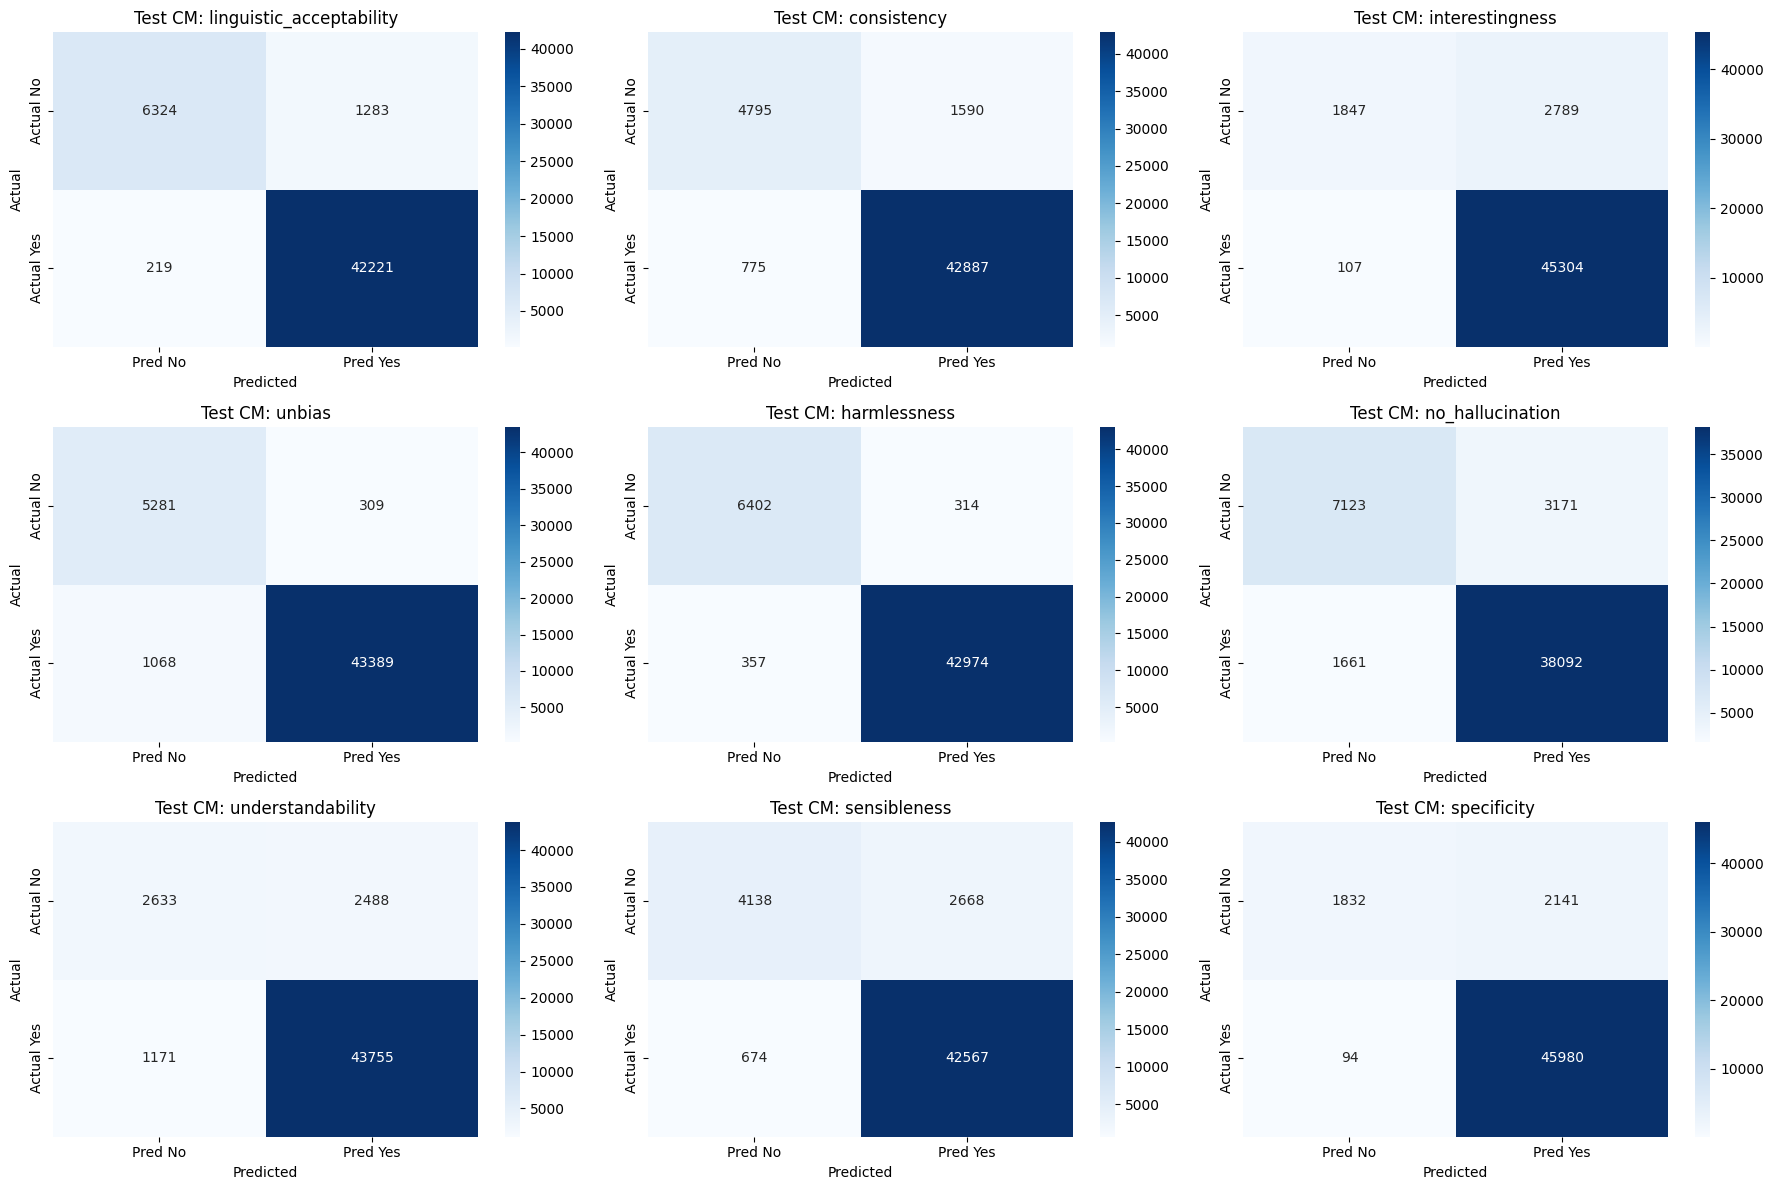

In [ ]:
# 1. 학습된 최적의 모델로 Test 데이터 예측
print("Evaluating on Test Set...")
test_predictions = trainer.predict(encoded_test)

# 2. 결과 가공
test_logits = test_predictions.predictions[0] if isinstance(test_predictions.predictions, tuple) else test_predictions.predictions
test_probs = 1 / (1 + np.exp(-test_logits))
test_y_pred = (test_probs >= 0.5).astype(int)
test_y_true = test_predictions.label_ids.astype(int)

# 3. 최종 성능 지표 출력
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\n[Final Test Report]")
for i, label in enumerate(labels):
    print(f"\nTarget: {label}")
    print(classification_report(test_y_true[:, i], test_y_pred[:, i], target_names=['No', 'Yes']))

# 4. Confusion Matrix 출력 및 시각화
print("\nPlotting Confusion Matrices...")
test_mcm = multilabel_confusion_matrix(test_y_true, test_y_pred)

plt.figure(figsize=(18, 12))
for i, (label, matrix) in enumerate(zip(labels, test_mcm)):
    plt.subplot(3, 3, i + 1)
    # annot=True: 숫자 표시, fmt='d': 정수 형식
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred No', 'Pred Yes'],
                yticklabels=['Actual No', 'Actual Yes'])
    plt.title(f'Test CM: {label}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

plt.tight_layout()
plt.show()

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

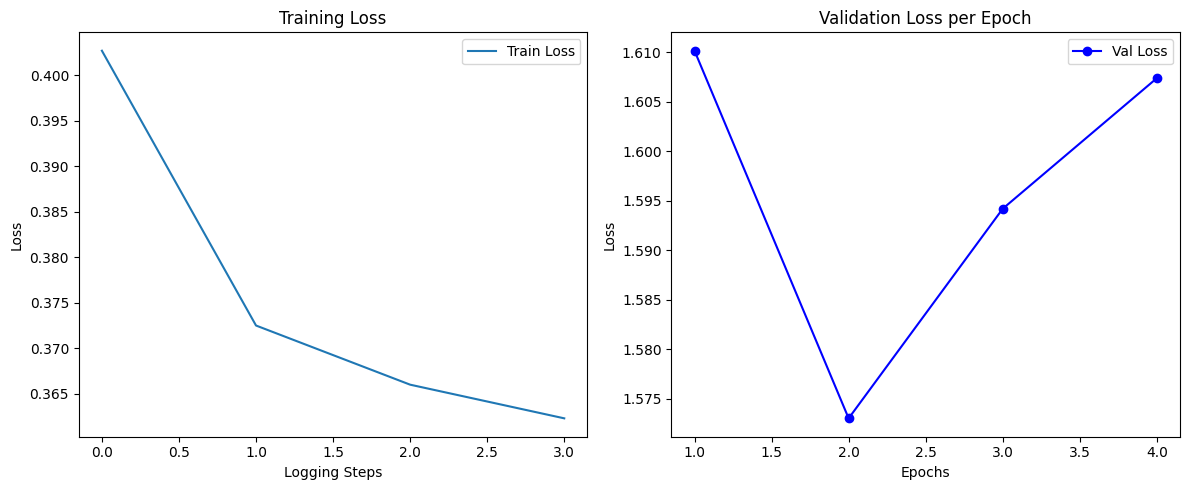

In [ ]:
# Visualization of Loss and Metrics
history = trainer.state.log_history

train_loss = [h['loss'] for h in history if 'loss' in h]
eval_loss = [h['eval_loss'] for h in history if 'eval_loss' in h]
epochs = range(1, len(eval_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Logging Steps')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_loss, 'bo-', label='Val Loss')
plt.title('Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

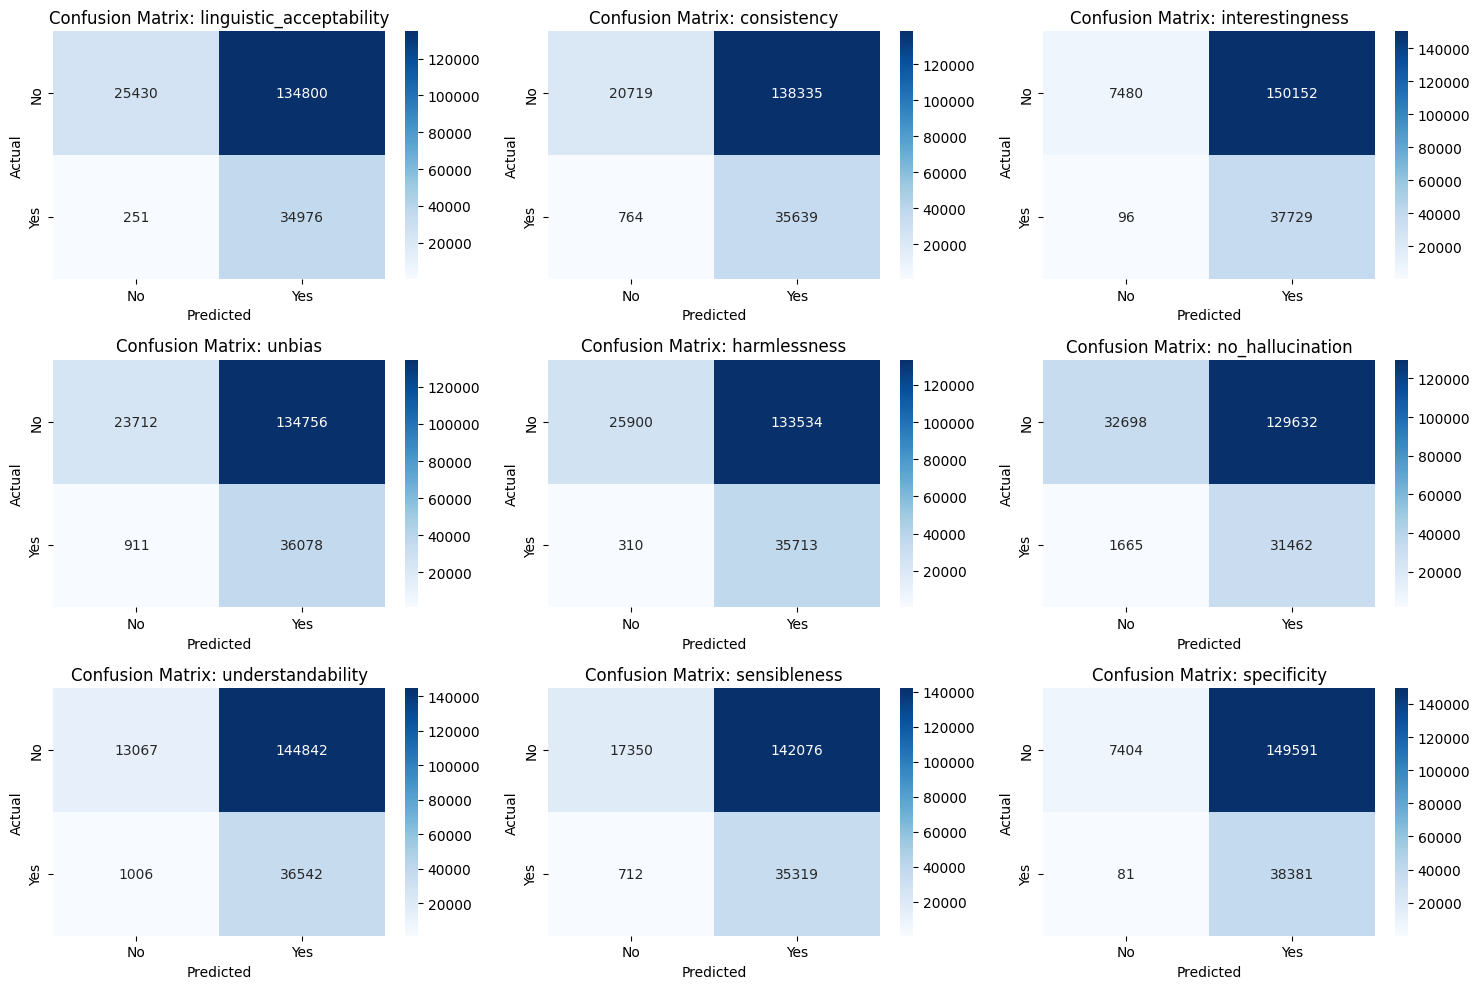

In [ ]:
# Confusion Matrix for Multi-label
predictions = trainer.predict(encoded_val)
logits = predictions.predictions[0] if isinstance(predictions.predictions, tuple) else predictions.predictions
probs = 1 / (1 + np.exp(-logits))
y_pred = (probs >= 0.5).astype(int)
y_true = predictions.label_ids.astype(int)

mcm = multilabel_confusion_matrix(y_true, y_pred)

plt.figure(figsize=(15, 10))
for i, (label, matrix) in enumerate(zip(labels, mcm)):
    plt.subplot(3, 3, i+1)
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title(f'Confusion Matrix: {label}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

plt.tight_layout()
plt.show()

# Task
주어진 학습 데이터셋에서 9개 레이블('yes'/'no')의 분포를 분석하여 레이블 불균형을 시각화하고, 이를 해결하기 위해 학습 과정에 클래스 가중치와 Early Stopping을 적용하여 모델을 재학습시키고 평가합니다. 또한, 모델 성능을 최적화하기 위한 하이퍼파라미터 튜닝 전략을 수립합니다.

## 레이블 불균형 분석

### Subtask:
학습 데이터셋에서 각 9개 레이블('yes'/'no')의 분포를 계산하고 시각화하여 잠재적인 클래스 불균형 문제를 식별합니다. 이는 모델 성능에 영향을 미칠 수 있습니다.


In [ ]:
label_distribution = {}

for label in labels:
    yes_count = consolidated_train_df[label].value_counts().get('yes', 0)
    no_count = consolidated_train_df[label].value_counts().get('no', 0)
    total_count = yes_count + no_count

    if total_count > 0:
        yes_percentage = (yes_count / total_count) * 100
        no_percentage = (no_count / total_count) * 100
    else:
        yes_percentage = 0
        no_percentage = 0

    label_distribution[label] = {
        'yes_count': yes_count,
        'no_count': no_count,
        'yes_percentage': yes_percentage,
        'no_percentage': no_percentage
    }

# Print the calculated distributions
print("Label Distribution (Counts and Percentages) in Training Data:")
for label, data in label_distribution.items():
    print(f"\nLabel: {label}")
    print(f"  Yes: {data['yes_count']} ({data['yes_percentage']:.2f}%)")
    print(f"  No: {data['no_count']} ({data['no_percentage']:.2f}%) ")


Label Distribution (Counts and Percentages) in Training Data:

Label: linguistic_acceptability
  Yes: 304492 (76.63%)
  No: 92882 (23.37%) 

Label: consistency
  Yes: 313733 (78.95%)
  No: 83641 (21.05%) 

Label: interestingness
  Yes: 325576 (81.93%)
  No: 71798 (18.07%) 

Label: unbias
  Yes: 318877 (80.25%)
  No: 78497 (19.75%) 

Label: harmlessness
  Yes: 310923 (78.24%)
  No: 86451 (21.76%) 

Label: no_hallucination
  Yes: 285630 (71.88%)
  No: 111744 (28.12%) 

Label: understandability
  Yes: 322171 (81.08%)
  No: 75203 (18.92%) 

Label: sensibleness
  Yes: 310820 (78.22%)
  No: 86554 (21.78%) 

Label: specificity
  Yes: 330910 (83.27%)
  No: 66464 (16.73%) 


/tmp/ipython-input-1512950677.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='Count', data=data, ax=axes[i], palette={'Yes': 'skyblue', 'No': 'salmon'})
/tmp/ipython-input-1512950677.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='Count', data=data, ax=axes[i], palette={'Yes': 'skyblue', 'No': 'salmon'})
/tmp/ipython-input-1512950677.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='Count', data=data, ax=axes[i], palette={'Yes': 'skyblue', 'No': 'salmon'})
/tmp/ipython-input-151

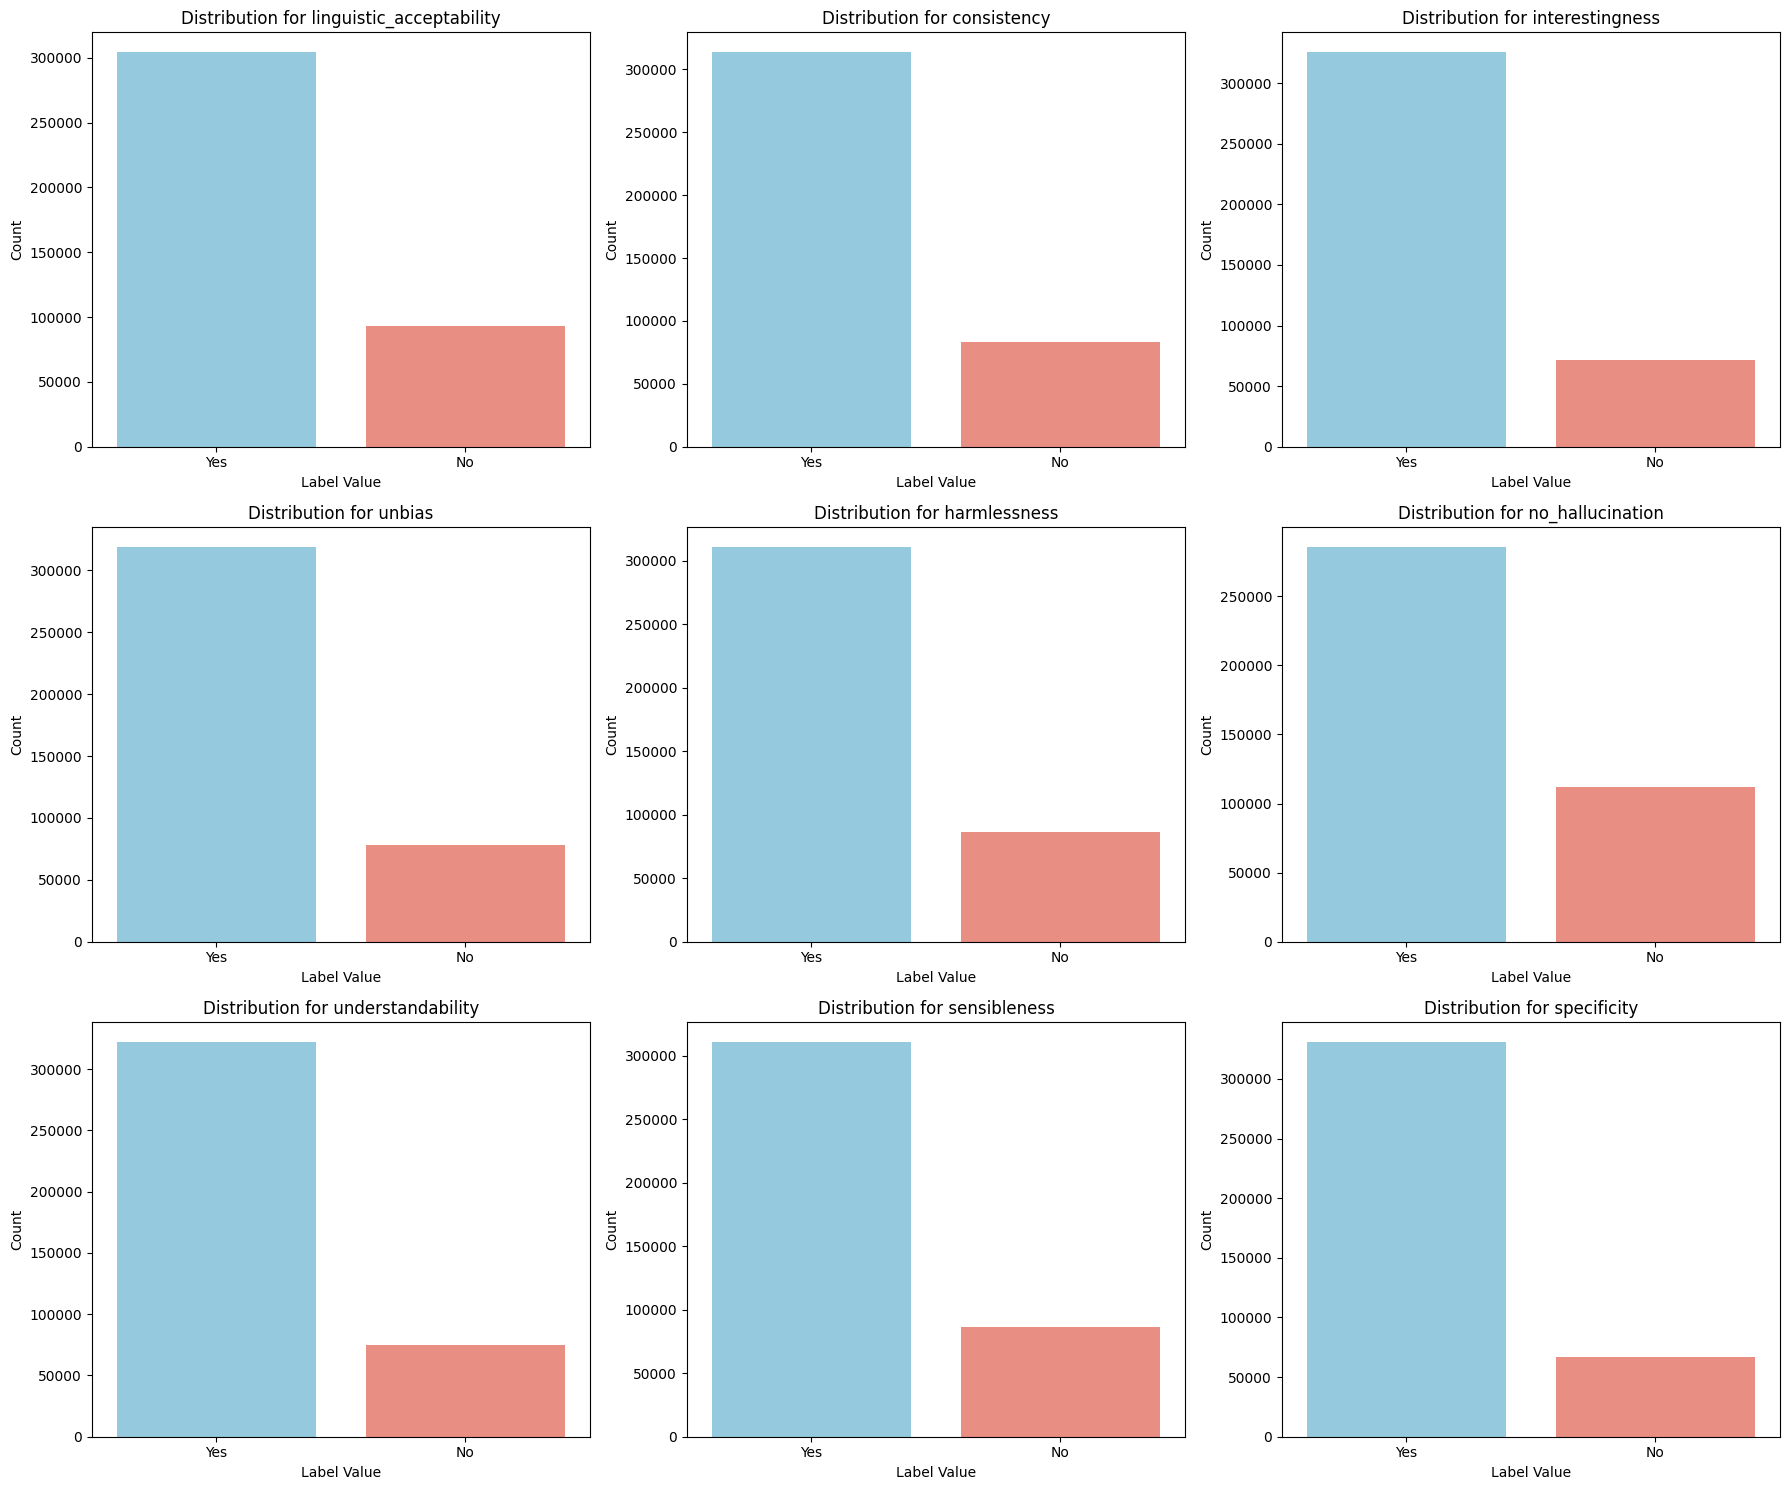


Analysis of Label Distribution:
The bar plots clearly show that for all 9 labels, the 'Yes' category significantly outnumbers the 'No' category. This indicates a strong class imbalance where the positive class ('Yes') is much more prevalent than the negative class ('No'). This imbalance could negatively impact model training, leading to a bias towards predicting 'Yes' and potentially poor performance on the minority 'No' class.


In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, label in enumerate(labels):
    yes_count = label_distribution[label]['yes_count']
    no_count = label_distribution[label]['no_count']

    data = pd.DataFrame({
        'Category': ['Yes', 'No'],
        'Count': [yes_count, no_count]
    })

    sns.barplot(x='Category', y='Count', data=data, ax=axes[i], palette={'Yes': 'skyblue', 'No': 'salmon'})
    axes[i].set_title(f'Distribution for {label}')
    axes[i].set_xlabel('Label Value')
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

print("\nAnalysis of Label Distribution:")
print("The bar plots clearly show that for all 9 labels, the 'Yes' category significantly outnumbers the 'No' category. This indicates a strong class imbalance where the positive class ('Yes') is much more prevalent than the negative class ('No'). This imbalance could negatively impact model training, leading to a bias towards predicting 'Yes' and potentially poor performance on the minority 'No' class.")

## 클래스 가중치 구현

### Subtask:
식별된 레이블 불균형을 해결하기 위해 학습 과정에 클래스 가중치를 적용합니다. 이는 과소 대표되는 클래스에 더 높은 가중치를 부여하여 모델이 해당 클래스에서 더 효과적으로 학습하도록 돕습니다.


In [ ]:
pos_weights = []
for label in labels:
    data = label_distribution[label]
    no_count = data['no_count']
    yes_count = data['yes_count']
    if yes_count > 0:
        pos_weight = no_count / yes_count
    else:
        pos_weight = 1.0 # Handle cases where there are no 'yes' samples
    pos_weights.append(pos_weight)

# Convert to PyTorch tensor and move to device
pos_weights_tensor = torch.tensor(pos_weights, dtype=torch.float32)

# Check if CUDA is available and move tensor to GPU, otherwise keep on CPU
if torch.cuda.is_available():
    pos_weights_tensor = pos_weights_tensor.to('cuda')

print("Calculated pos_weights for each label:")
for i, label in enumerate(labels):
    print(f"  {label}: {pos_weights_tensor[i].item():.4f}")
print(f"pos_weights_tensor device: {pos_weights_tensor.device}")

Calculated pos_weights for each label:
  linguistic_acceptability: 0.3050
  consistency: 0.2666
  interestingness: 0.2205
  unbias: 0.2462
  harmlessness: 0.2780
  no_hallucination: 0.3912
  understandability: 0.2334
  sensibleness: 0.2785
  specificity: 0.2009
pos_weights_tensor device: cuda:0


In [ ]:
from torch import nn

class CustomWeightedTrainer(Trainer):
    def __init__(self, *args, pos_weights, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos_weights = pos_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = nn.BCEWithLogitsLoss(pos_weight=self.pos_weights)
        loss = loss_fct(logits, labels.float())

        return (loss, outputs) if return_outputs else loss

print("CustomWeightedTrainer class defined successfully.")

CustomWeightedTrainer class defined successfully.


In [ ]:
training_args_weighted = TrainingArguments(
    output_dir=os.path.join(args.output_dir, "weighted_model"), # A new output directory for the weighted model
    learning_rate=args.learning_rate,
    per_device_train_batch_size=args.batch_size,
    per_device_eval_batch_size=args.valid_batch_size,
    gradient_accumulation_steps=args.accumulate_grad_batches,
    num_train_epochs=args.epochs,
    weight_decay=args.weight_decay,
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    logging_dir='./logs_weighted',
    logging_strategy="steps",
    logging_steps=500,
    evaluation_strategy="steps",
    eval_steps=500,
    save_total_limit=1,
    save_steps=500
)

# Re-initialize the model to ensure a clean slate for training with weights
model_weighted = AutoModelForSequenceClassification.from_pretrained(
    args.model_path,
    problem_type="multi_label_classification",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    # Apply sigmoid
    probs = 1 / (1 + np.exp(-preds))
    y_pred = (probs >= 0.5).astype(int)
    y_true = p.label_ids.astype(int)

    # Metrics
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)

    return {
        'accuracy': accuracy,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro
    }

trainer_weighted = CustomWeightedTrainer(
    model=model_weighted,
    args=training_args_weighted,
    train_dataset=encoded_train,
    eval_dataset=encoded_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    pos_weights=pos_weights_tensor
)

print("Starting Training with Class Weights (corrected trainer)...")
train_result_weighted = trainer_weighted.train()

SAVE_PATH_WEIGHTED = os.path.join(args.output_dir, "weighted_finetuning_model")
trainer_weighted.save_model(SAVE_PATH_WEIGHTED)
tokenizer.save_pretrained(SAVE_PATH_WEIGHTED)



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2333461641.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomWeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Starting Training with Class Weights (corrected trainer)...


Step,Training Loss,Validation Loss,Accuracy,F1 Micro,F1 Macro
500,0.231000,0.837259,0.122114,0.337544,0.337367
1000,0.219800,0.806822,0.112623,0.335683,0.335366


Step,Training Loss,Validation Loss,Accuracy,F1 Micro,F1 Macro
500,0.231000,0.837259,0.122114,0.337544,0.337367
1000,0.219800,0.806822,0.112623,0.335683,0.335366
1500,0.216700,0.819352,0.113166,0.334447,0.334118


In [ ]:
# 1. 라이브러리 설치 및 로그인
!pip install huggingface_hub
from huggingface_hub import notebook_login
# 실행 후 뜨는 입력창에 Hugging Face 'Write' 토큰을 입력하세요.
# 토큰 확인: https://huggingface.co/settings/tokens
notebook_login()

In [ ]:
# 2. 모델 업로드 설정
repo_id = "jjjh02/klue-roberta_full_fine_tuning"  # 예: "jinsuhhur/roberta-lora-utterance-eval"
save_path = SAVE_PATH  # 로컬에 저장된 모델 경로
# 1단계에서 학습했던 모델과 토크나이저를 다시 로드하거나
# 저장된 경로에서 바로 업로드할 수 있습니다.
from transformers import AutoTokenizer, AutoModelForSequenceClassification
print(f"Uploading model to {repo_id}...")
# 방법 A: 저장된 파일을 직접 업로드 (가장 확실함)
# Trainer 객체가 살아있다면 trainer.push_to_hub(repo_id) 도 가능합니다.
# 여기서는 저장된 가중치를 불러와서 올리는 방식을 사용합니다.
tokenizer = AutoTokenizer.from_pretrained(save_path)
model = AutoModelForSequenceClassification.from_pretrained(save_path)
# Hub로 푸시
model.push_to_hub(repo_id)
tokenizer.push_to_hub(repo_id)
